# GLS and Spatial Autocorrelation model fitting

## Read the data from Juan David
I'm going to include a link to the datasource


In [60]:
# Load Biospytial modules and etc.
%matplotlib inline
import sys
sys.path.append('/apps')
sys.path.append('..')
sys.path.append('../../spystats')
import django
django.setup()
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
## Use the ggplot style
plt.style.use('ggplot')

import tools
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [61]:
import os
input_path = "/RawDataCSV/DN_plot.data/"

In [62]:
filenames = os.listdir(input_path)
fullpath = map(lambda name : input_path+name,filenames)
pds = map(lambda file : pd.read_csv(file), fullpath)

In [63]:
sizes = map(lambda p : p.shape[0],pds)

In [64]:
sizes

[100000,
 200000,
 300000,
 150000,
 300000,
 450000,
 200000,
 400000,
 600000,
 50000,
 100000,
 150000,
 100000,
 200000,
 300000,
 150000,
 300000,
 450000,
 200000,
 400000,
 600000,
 50000,
 100000,
 150000]

In [65]:
t1 = fullpath[0]
nd = pd.read_csv(t1)

In [66]:
## We group by simulation index

In [67]:
groups = nd.groupby(['sim'])

In [68]:
##  PCOnvert to list to extract appropiate sub fitting, this will be expanded further

In [69]:
gg = list(groups)

## Selecting one group

In [70]:
t1 = gg[0][1]

In [71]:
## Convert to geopandas
gt1 =  tools.toGeoDataFrame(t1,xcoord_name='lon',ycoord_name='lat')

In [72]:
## We need to reproject to Alberts or What ever

In [73]:
def prepareDataFrame(dataframe):
    """
    Reads the data and stores it in a geodataframe.
    """
    new_data = tools.toGeoDataFrame(dataframe,xcoord_name='lon',ycoord_name='lat')
    logger.info("Reprojecting to Alberts equal area")
    new_data =  new_data.to_crs("+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 +lon_0=-96 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs ")
    new_data['logBiomass'] = new_data.apply(lambda x : np.log(x.plotBiomass),axis=1)
    new_data['newLon'] = new_data.apply(lambda c : c.geometry.x, axis=1)
    new_data['newLat'] = new_data.apply(lambda c : c.geometry.y, axis=1)
    new_data['logBiomass'] = np.log(new_data.plotBiomass)
    new_data['logSppN'] = np.log(new_data.SppN)
    logger.info("Removing possible duplicates. \n This avoids problems of Non Positive semidefinite")
    new_data = new_data.drop_duplicates(subset=['newLon','newLat'])
    return new_data

In [77]:
ngt1 = prepareDataFrame(t1)
sill = 0.340246718396
range_ = 41188.0234423 # (meters)
nugget = 0.329937603763
alpha = 1.12143687914 
wm = tools.WhittleVariogram(nugget=nugget,sill=sill,range_a=range_,alpha=alpha)
vg1 = tools.Variogram(ngt1,'logSppN',model=wm)
vg1.distance_threshold = 100000
vg1.fitVariogramModel(wm)

ERROR:tools:This model  does not support more than 3 parameters


TypeError: Improper input: N=4 must not exceed M=0

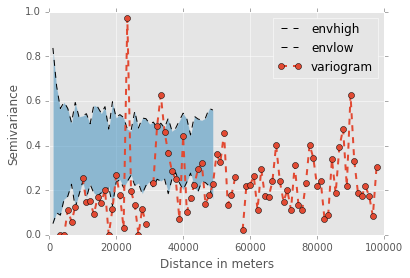

In [80]:

vg1.plot(with_envelope=True,n_bins=100)
vg1.plot??

## Let's use as initial guess the same parameters than the one obtained in the global variogram.
> This is a first pragmatic decision there are other ways to achieve this, like the likelihood approach.

To keep consistency with the global model (based on moment-based estimation) .

In [79]:
vg1.fitVariogramModel(wm)

< Whittle Variogram : sill 0.253579965123, range 14584.5091955, nugget 0.152226938744, alpha1.75048601477 >

In [40]:
wm

< Whittle Variogram : sill 0.253580823739, range 14587.3424731, nugget 0.152375897495, alpha1.75090498308 >

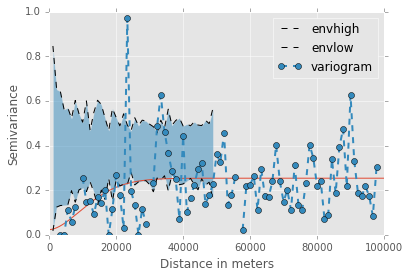

In [41]:
x = np.linspace(0,100000,10000)
plt.plot(x,vg1.model.f(x))
vg1.plot(with_envelope=True,n_bins=100)

In [42]:
import statsutils as st

In [ ]:
def prepareDataFrame(dataframe):
    """
    Reads the data and stores it in a geodataframe.
    """
    new_data = tools.toGeoDataFrame(dataframe,xcoord_name='lon',ycoord_name='lat')
    logger.info("Reprojecting to Alberts equal area")
    new_data =  new_data.to_crs("+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 +lon_0=-96 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs ")
    new_data['logBiomass'] = new_data.apply(lambda x : np.log(x.plotBiomass),axis=1)
    new_data['newLon'] = new_data.apply(lambda c : c.geometry.x, axis=1)
    new_data['newLat'] = new_data.apply(lambda c : c.geometry.y, axis=1)
    new_data['logBiomass'] = np.log(new_data.plotBiomass)
    new_data['logSppN'] = np.log(new_data.SppN)
    logger.info("Removing possible duplicates. \n This avoids problems of Non Positive semidefinite")
    new_data = new_data.drop_duplicates(subset=['newLon','newLat'])
    return new_data

In [81]:
def prepareAndFitModel(dataframe,n_bins=100):
    """
    Hard coded function for fitting the model.
    """
    geodataframe = prepareDataFrame(dataframe)
    sill = 0.340246718396
    range_ = 41188.0234423 # (meters)
    nugget = 0.329937603763
    alpha = 1.12143687914 
    wm = tools.WhittleVariogram(nugget=nugget,sill=sill,range_a=range_)
    vg = tools.Variogram(geodataframe,'logSppN',model=wm)
    vg.distance_threshold = 100000
    vg.calculateEmpirical(n_bins=n_bins)
    vg.fitVariogramModel(wm)
    model,results = st.fitLinearLogLogModel(geodataframe)
    geodataframe['residuals'] = results.resid
    fitted_values = st.fitGLSRobust(geodataframe,vg,distance_threshold=100000)
    return fitted_values
    #return vg

In [87]:
resum,variogram,resultspd,results = prepareAndFitModel(t1)

INFO:statsutils:Fitting OLS linear model: logBiomass ~ logSppN 
INFO:statsutils:Building Spatial Covariance Matrix
INFO:statsutils:Calculating Distance Matrix
INFO:statsutils:Calculating GLS estimators
INFO:statsutils:Fitting linear model using GLS
INFO:statsutils:RESULTS::: n_obs: 100.0, r-squared: 0.741597826409, {{"Intercept":8.1381818069,"logSppN":0.5877675145},{"Intercept":1.873627897e-73,"logSppN":0.0000000609},{"0":{"Intercept":7.8297464107,"logSppN":0.3888848089},"1":{"Intercept":8.4466172031,"logSppN":0.78665022}}}
INFO:statsutils:Recalculating variogram
INFO:statsutils:Refiting Theoretical Variogram
INFO:statsutils:Variogram parameters: range 3945.62545892, sill 0.499275129871, nugget 0.581023415479
INFO:statsutils:Building Spatial Covariance Matrix
INFO:statsutils:Calculating Distance Matrix
INFO:statsutils:Calculating GLS estimators
INFO:statsutils:Fitting linear model using GLS
INFO:statsutils:RESULTS::: n_obs: 100.0, r-squared: 0.813765995021, {{"Intercept":8.1420716092,"

In [94]:
## We will apply this function to all the data in the grpds 

cosas = map(lambda pd : prepareAndFitModel(pd),pds)


MemoryError: 

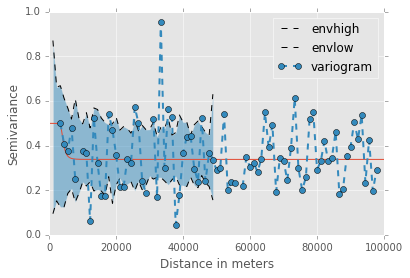

In [89]:
x = np.linspace(0,100000,10000)
plt.plot(x,variogram.model.f(x))
variogram.plot(with_envelope=True,n_bins=100)

In [91]:
nd.groupby?

In [ ]:
ngt1['logBiomass','logSppN','lon','lat','newLon','newLat']